# Case Study 1

#### Model selection for Clustering

Clustering is unsupervised learning: the resulting clusters are completely derived from data distributed in given a feature set with no class available

Compared to supervised learning counterparts, it is …
* hard to define model performance (cluster quality)
* sensitive to different clustering algorithms and different feature spaces.



#### Task
Your task is to try different clustering algorithms and also a range of the potential parameter(s) which affect the number of clusters including ..

* K-means
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
* Gaussian Mixture Model, 
https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
* Hierarchical Clustering, 
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering
* Louvain Clustering, 
https://scikit-network.readthedocs.io/en/latest/reference/clustering.html#module-sknetwork.clustering

on 5K colorectal patches represented by 4 different representation PathologyGAN, ResNet50, InceptionV3 and VGG16


#### Data and its preprocessing 
5,000 non-overlapping image patches from hematoxylin & eosin (H&E) stained histological images of human colorectal cancer (CRC) and normal tissue.
* 4 feature sets, PathologyGAN, ResNet50, InceptionV3 and VGG16, are extracted to represent those 5,000 images different dimensional feature spaces.
* PCA and UMAP were employed to reduce each feature sapce into 100-dimensional vectors

* 9 tissue types are also available which include Adipose (ADI), background (BACK), debris (DEB), lymphocytes (LYM), mucus (MUC), smooth muscle (MUS), normal colon mucosa (NORM), cancer-associated stroma (STR), colorectal adenocarcinoma epithelium (TUM)


#### Performance Measurement
To assess quality of clustering solutions, several approaches are expected to be done and interpreted which include...
* Silhouette Score for goodness of fit test
* Vmeasure Score for homogeneity and completeness test (tissue type available as ground truth)
* Clusters visualisations

For more information, please have a check...
https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation


#### Report
Report on your preprocessing pipeline, theory and intuition behinds each algorithm and representation, parameter searching and performance evaluation frameworks. If there is any addiotional process, give evidences/justifications on how it helps.

#### Required Packages

In [74]:
# !pip install h5py==2.10.0
# !pip install numpy
# !pip install pandas
# !pip install sklearn
# !pip install scikit-network
# !pip install pickle-mixin==1.0.2
# !pip install matplotlib
# !pip install plotly

### Prepare Tissue Representations

In [75]:
import h5py
import numpy as np
import pickle

In [76]:
pge_path = 'colon_nct_feature/pge_dim_reduced_feature.h5'
resnet50_path = 'colon_nct_feature/resnet50_dim_reduced_feature.h5'
inceptionv3_path = 'colon_nct_feature/inceptionv3_dim_reduced_feature.h5'
vgg16_path = 'colon_nct_feature/vgg16_dim_reduced_feature.h5'

pge_content = h5py.File(pge_path, mode='r')
resnet50_content = h5py.File(resnet50_path, mode='r')
inceptionv3_content = h5py.File(inceptionv3_path, mode='r')
vgg16_content = h5py.File(vgg16_path, mode='r')


In [77]:
#PCA feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_pca_feature  = pge_content['pca_feature'][...]
resnet50_pca_feature  = resnet50_content['pca_feature'][...]
inceptionv3_pca_feature = inceptionv3_content['pca_feature'][...]
vgg16_pca_feature  = vgg16_content['pca_feature'][...]

In [78]:
#UMAP feature from 4 feature sets: pge_latent, resnet50_latent, inceptionv3_latent, vgg16_latent
pge_umap_feature  = pge_content['umap_feature'][...]
resnet50_umap_feature = resnet50_content['umap_feature'][...]
inceptionv3_umap_feature  = inceptionv3_content['umap_feature'][...]
vgg16_umap_feature  = vgg16_content['umap_feature'][...]

In [79]:
#tissue type as available ground-truth: labels
filename  = np.squeeze(pge_content['file_name'])
labels = np.array([str(x).split('/')[2] for x in filename])


# Example

In [80]:
import random

In [81]:
random.seed(0)
selected_index = random.sample(list(np.arange(len(pge_pca_feature))), 200)

test_data = pge_pca_feature[selected_index]
test_label = labels[selected_index]

### Exploratory Analysis

In [82]:
import plotly.graph_objects as go
import pandas as pd

In [83]:
traces = []
for name in np.unique(labels):
    trace = go.Scatter3d(
        x=test_data[test_label==name,0],
        y=test_data[test_label==name,1],
        z=test_data[test_label==name,2],
        mode='markers',
        name=name,
        marker=go.scatter3d.Marker(
            size=4,
            opacity=0.8
        )

    )
    traces.append(trace)


data = go.Data(traces)
layout = go.Layout(
            showlegend=True,
    scene=go.Scene(
                xaxis=go.layout.scene.XAxis(title='PC1'),
                yaxis=go.layout.scene.YAxis(title='PC2'),
                zaxis=go.layout.scene.ZAxis(title='PC3')
                )
)
fig = go.Figure(data=data, layout=layout)
fig.update_layout(
    title="First 3 pricipal components of PathologyGAN's PCA feature",
    legend_title="Legend Title",
)

fig.show()


c:\Users\Sahil Gaurkar\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:31: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.


c:\Users\Sahil Gaurkar\AppData\Local\Programs\Python\Python310\lib\site-packages\plotly\graph_objs\_deprecations.py:489: DeprecationWarning:

plotly.graph_objs.Scene is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Scene




### Model

In [84]:
# for K-Means
from sklearn.cluster import KMeans
from sknetwork.clustering import Louvain

In [85]:
# for Louvain clustering
from sklearn.metrics import pairwise_distances 
from sklearn.preprocessing import MinMaxScaler
from scipy import sparse


In [86]:
#for GMM
from sklearn.mixture import GaussianMixture

### Evaluation

In [87]:
from sklearn.metrics import silhouette_score, v_measure_score
from sklearn.model_selection import KFold, train_test_split
from decimal import *

In [88]:
def calculate_percent(sub_df, attrib):
    cnt = sub_df[attrib].count()
    output_sub_df = sub_df.groupby(attrib).count()
    return (output_sub_df/cnt)

* Assess goodness of fit by silhouette score and cluster homogeneities by V-measure

In [89]:
def k_means_scores(feature, cluster):
    kmeans_silhouettes = []
    for i in range(2,cluster+1,1):
        kmeans_model = KMeans(n_clusters = i, random_state = 0) 
        kmeans_assignment = kmeans_model.fit_predict(feature)
        kmeans_silhouette = silhouette_score(feature, kmeans_assignment)
        kmeans_silhouettes.append(kmeans_silhouette)
    maxscore = max(kmeans_silhouettes)
    maxindex = kmeans_silhouettes.index(maxscore) + 2
    return kmeans_silhouettes, maxindex

In [90]:
def louvian_scores(feature, res, obj_func, rand_state, max_res):
    louvain_silhouettes = []
    adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(feature)))
    max = 0
    max_score = 0
    while res < max_res :
        louvain_model = Louvain(resolution = res, modularity = obj_func, random_state = rand_state) 
        louvain_assignment = louvain_model.fit_transform(adjacency_matrix)
        louvain_silhouette = silhouette_score(feature, louvain_assignment)
        louvain_silhouettes.append(louvain_silhouette)
        if max_score < louvain_silhouette:
            max_score = louvain_silhouette
            max = res
        res = res + 0.01
    return louvain_silhouettes, round(max,4)

In [91]:
def gmm_scores(feature, component):
    gmm_silhouettes = []
    for i in range(2,component+1,1):
        gmm_model = GaussianMixture(n_components = i, random_state = 0) 
        gmm_assignment = gmm_model.fit_predict(feature)
        gmm_silhouette = silhouette_score(feature, gmm_assignment)
        gmm_silhouettes.append(gmm_silhouette)
    maxscore = max(gmm_silhouettes)
    maxindex = gmm_silhouettes.index(maxscore) + 2
    return gmm_silhouettes, maxindex

### Visualisation

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', figsize=(8.0, 4.0), dpi=140)
from IPython.display import display

In [93]:
def display_info(kmeans_assignment,louvain_assignment,gmm_assignment,feature):   
    kmeans_silhouette = silhouette_score(feature, kmeans_assignment)
    kmeans_v_measure = v_measure_score(labels, kmeans_assignment)
    louvain_silhouette = silhouette_score(feature, louvain_assignment)
    louvain_v_measure = v_measure_score(labels, louvain_assignment)
    gmm_silhouette = silhouette_score(feature, gmm_assignment)
    gmm_v_measure = v_measure_score(labels, gmm_assignment)
    
    kmeans_counts = np.unique(kmeans_assignment, return_counts = True)
    louvain_counts = np.unique(louvain_assignment, return_counts = True)
    gmm_counts = np.unique(gmm_assignment, return_counts = True)
    
    print('Kmeans assignment counts')
    display(pd.DataFrame({'Cluster Index': kmeans_counts[0], 'Number of members':kmeans_counts[1]}).set_index('Cluster Index'))
    print('Louvain assignment counts')
    display(pd.DataFrame({'Cluster Index': louvain_counts[0], 'Number of members':louvain_counts[1]}).set_index('Cluster Index'))
    display(pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure]}).set_index('Metrics'))
    print('GMM assignment counts')
    display(pd.DataFrame({'Cluster Index': gmm_counts[0], 'Number of members':gmm_counts[1]}).set_index('Cluster Index'))
    display(pd.DataFrame({'Metrics': ['silhouette', 'V-measure'], 'Kmeans': [kmeans_silhouette, kmeans_v_measure], 'Louvain':[louvain_silhouette, louvain_v_measure], 'GMM':[gmm_silhouette, gmm_v_measure]}).set_index('Metrics'))

In [94]:
def plot_kmeans_scores(x):
    plt.grid()
    plt.plot(np.arange(2,len(x)+2,1),x,'bs-', label = "silhouette scores")
    plt.xlabel('Clusters')
    plt.ylabel('Score')
    plt.xticks(np.arange(2,len(x)+2,1))
    plt.title('Silhouette scores')
    plt.legend(loc="upper right")

In [95]:
def plot_gmm_scores(x):
    plt.grid()
    plt.plot(np.arange(2,len(x)+2,1),x,'bs-', label = "silhouette scores")
    plt.xlabel('Components')
    plt.ylabel('Score')
    plt.xticks(np.arange(2,len(x)+2,1))
    plt.title('Silhouette scores')
    plt.legend(loc="upper right")

In [96]:
def plot_louvian_scores(x, start_res, max_res):
    plt.grid()
    plt.plot(np.arange(start_res,max_res-0.01,0.01),x,'bs-', label = "silhouette scores")
    plt.xticks(np.arange(start_res,max_res-0.01,0.01), rotation='vertical')
    plt.xlabel('Resolution')
    plt.ylabel('Score')
    plt.title('Silhouette scores')
    plt.legend(loc="upper right")

In [97]:
def show_assignments(kmeans_assignment,louvain_assignment,gmm_assignment):
    resulted_cluster_df = pd.DataFrame({'clusterID': kmeans_assignment, 'type': labels})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
    pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')


    f, axes = plt.subplots(1, 3, figsize=(20,5))
    number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
    df_idx = pivoted_label_proportion_df.index
    (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[0] )

    axes[0].set_ylabel('Percentage of tissue type')
    axes[0].legend(loc='upper right')
    axes[0].set_title('Cluster configuration by Kmeans')

    resulted_cluster_df = pd.DataFrame({'clusterID': louvain_assignment, 'type': labels})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
    pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

    number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
    df_idx = pivoted_label_proportion_df.index
    (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[1] )

    axes[1].set_ylabel('Percentage of tissue type')
    axes[1].legend(loc='upper right')
    axes[1].set_title('Cluster configuration by Louvain')
    
    resulted_cluster_df = pd.DataFrame({'clusterID': gmm_assignment, 'type': labels})
    label_proportion_df = resulted_cluster_df.groupby(['clusterID']).apply(lambda x: calculate_percent(x,'type')).rename(columns={'clusterID':'type_occurrence_percentage'}).reset_index()
    pivoted_label_proportion_df = pd.pivot_table(label_proportion_df, index = 'clusterID', columns = 'type', values = 'type_occurrence_percentage')

    number_of_tile_df = resulted_cluster_df.groupby('clusterID')['type'].count().reset_index().rename(columns={'type':'number_of_tile'})
    df_idx = pivoted_label_proportion_df.index
    (pivoted_label_proportion_df*100).loc[df_idx].plot.bar(stacked=True, ax = axes[2] )

    axes[2].set_ylabel('Percentage of tissue type')
    axes[2].legend(loc='upper right')
    axes[2].set_title('Cluster configuration by GMM')
    
    f.show()

### Modeling and Evaluation

Data: PathologyGAN and Inceptionv3

Method: K-Mean, Louvian and GMM

Parameters for K-Means

In [98]:
cluster = 30

Parameters for Louvian

In [99]:
start_res = 0.9 #As we have 8 labels available we have to start from 0.9
max_res = 1.1 #Max values upto 1.1
obj_func = 'newman' #Select Objective Functions from : 'newman' or 'potts' undirected graph approch and not 'dugue' as this is an directed graph approch
random_state = 0

Parameters for GMM

In [100]:
component = 30

Best Score is 0.3079051375389099 for Clusters: 2


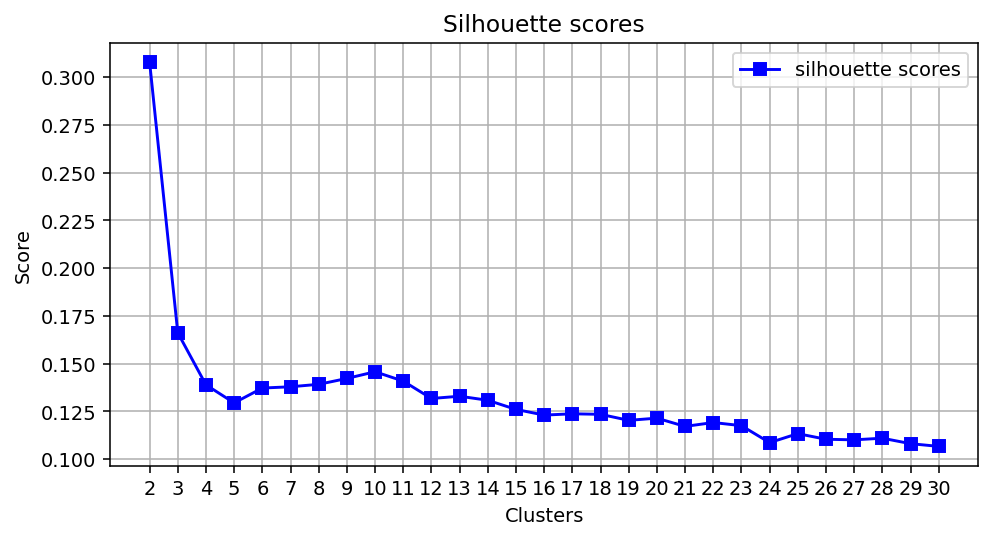

In [101]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(pge_pca_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.28796592354774475 for Resolution: 0.9


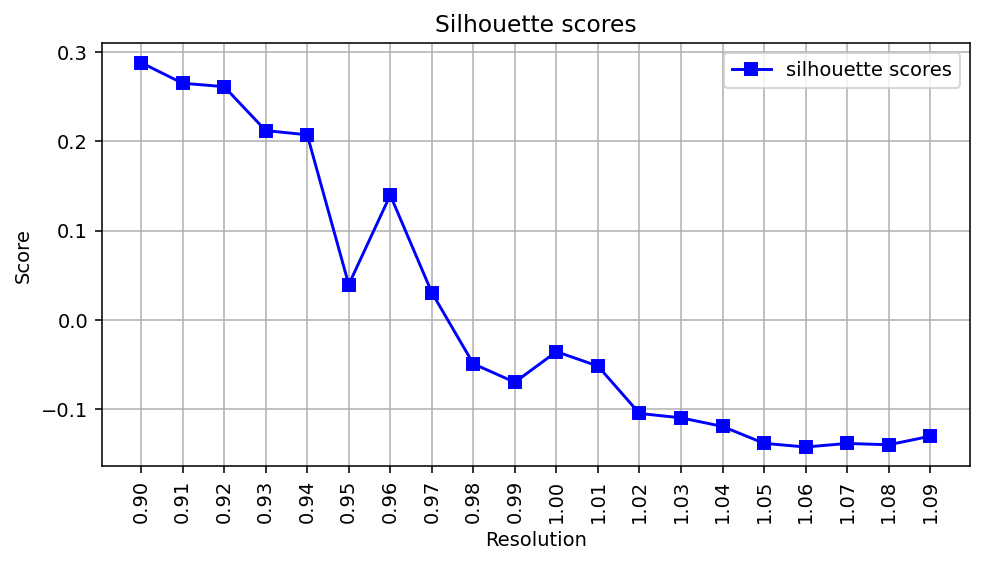

In [102]:
louvian_silhouettes, louvian_maxindex = louvian_scores(pge_pca_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Best Score is 0.19140297174453735 for Components: 2


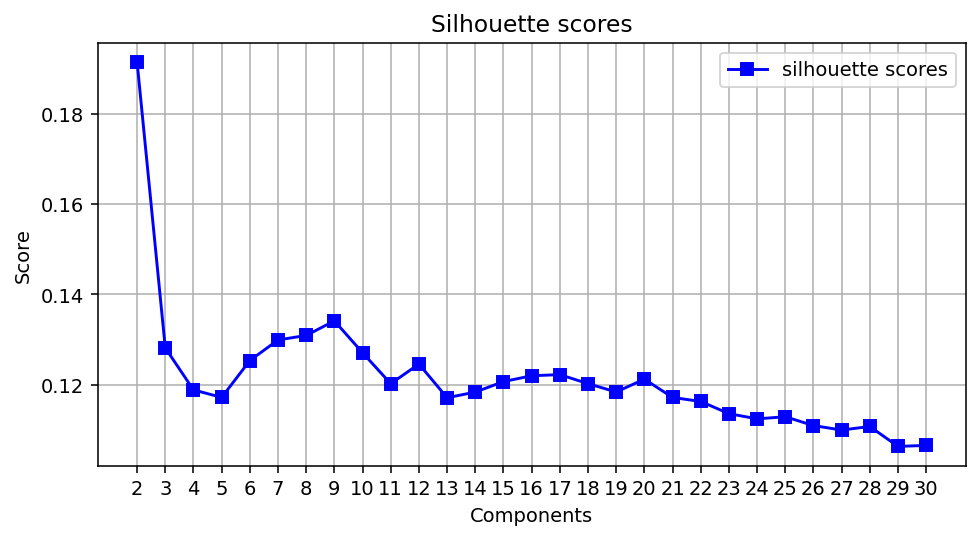

In [103]:
gmm_silhouettes, gmm_maxindex = gmm_scores(pge_pca_feature, component)
plot_gmm_scores(gmm_silhouettes)
print(f'Best Score is {max(gmm_silhouettes)} for Components: {gmm_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,1327
1,3673


Louvain assignment counts


,Number of members
Cluster Index,
0,3451
1,1549


,Kmeans,Louvain
Metrics,,
silhouette,0.307905,0.287966
V-measure,0.203311,0.215607


GMM assignment counts


,Number of members
Cluster Index,
0,2434
1,2566


,Kmeans,Louvain,GMM
Metrics,,,
silhouette,0.307905,0.287966,0.191403
V-measure,0.203311,0.215607,0.208618


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_12632\474630691.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



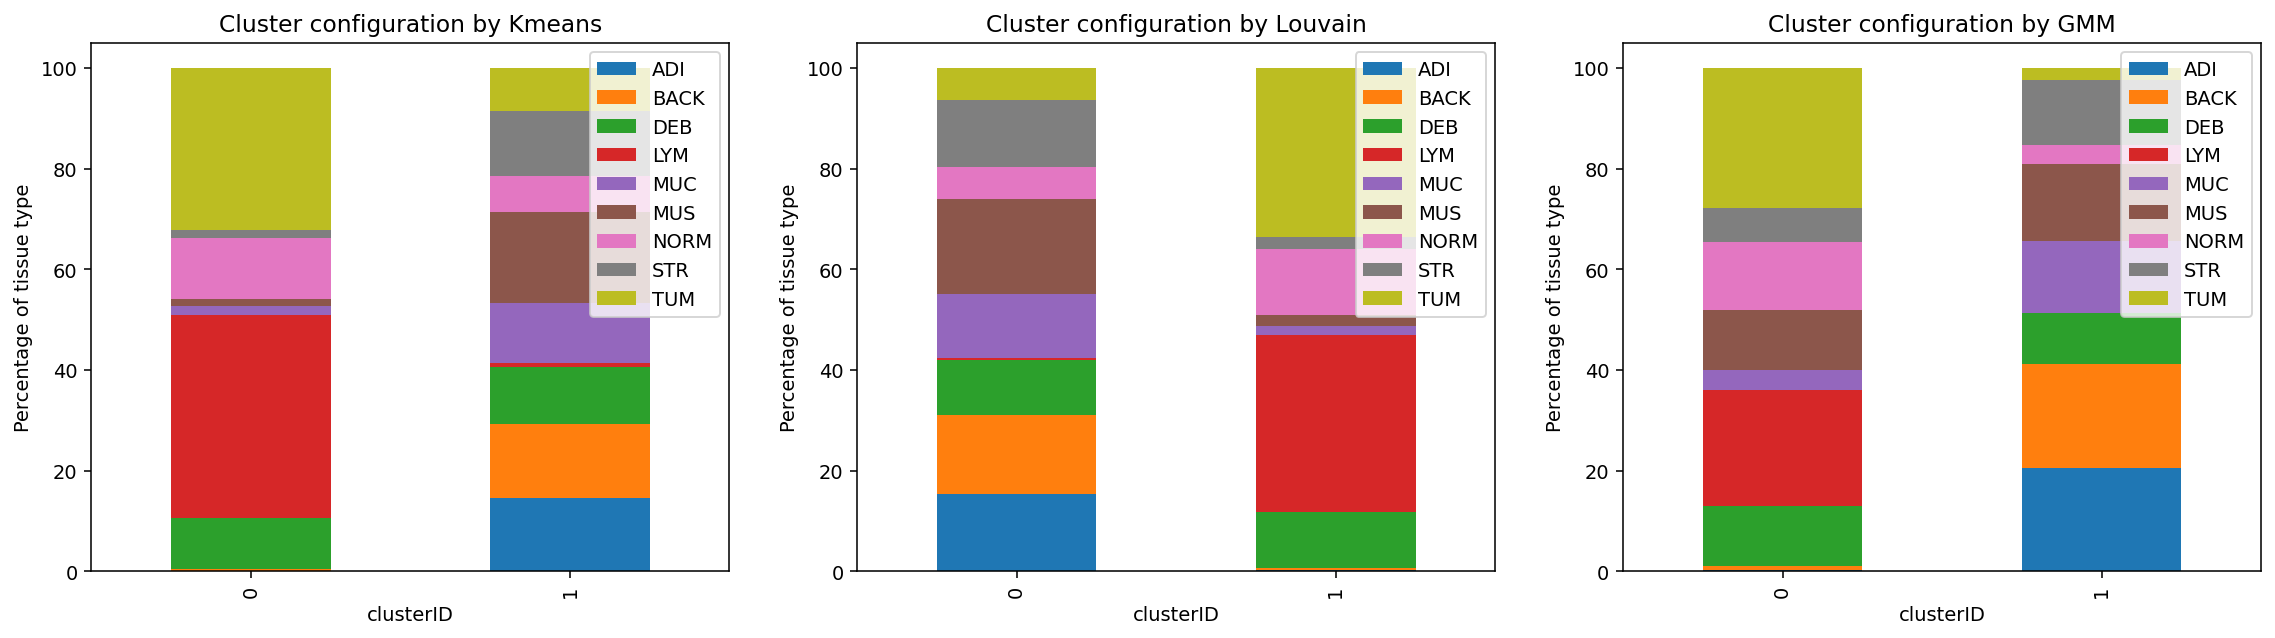

In [104]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(pge_pca_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_pca_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

gmm_model = GaussianMixture(n_components = gmm_maxindex, random_state = 0) 
gmm_assignment = gmm_model.fit_predict(pge_pca_feature)

display_info(kmeans_assignment,louvain_assignment,gmm_assignment,pge_pca_feature)
show_assignments(kmeans_assignment,louvain_assignment,gmm_assignment)

Best Score is 0.6156871914863586 for Clusters: 7


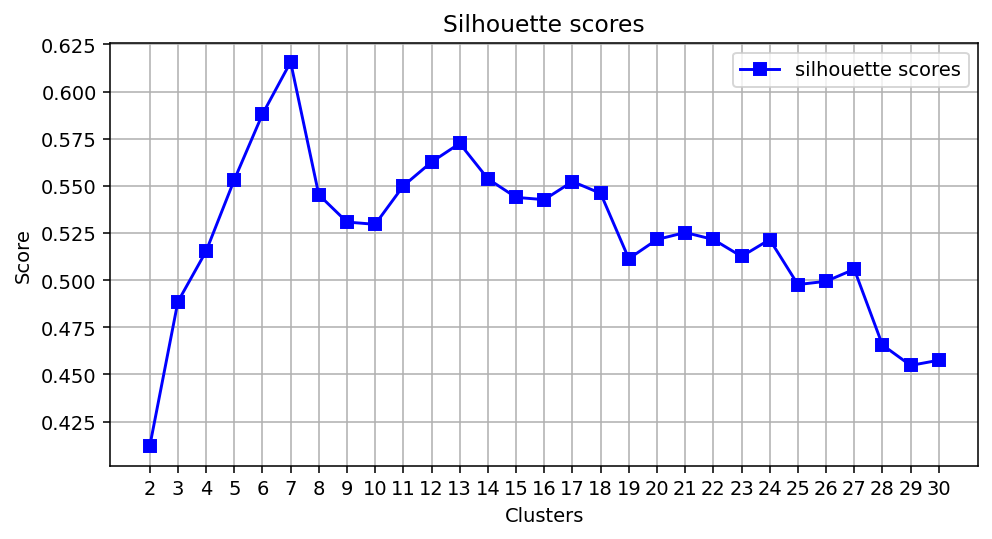

In [105]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(pge_umap_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.4055335819721222 for Resolution: 0.96


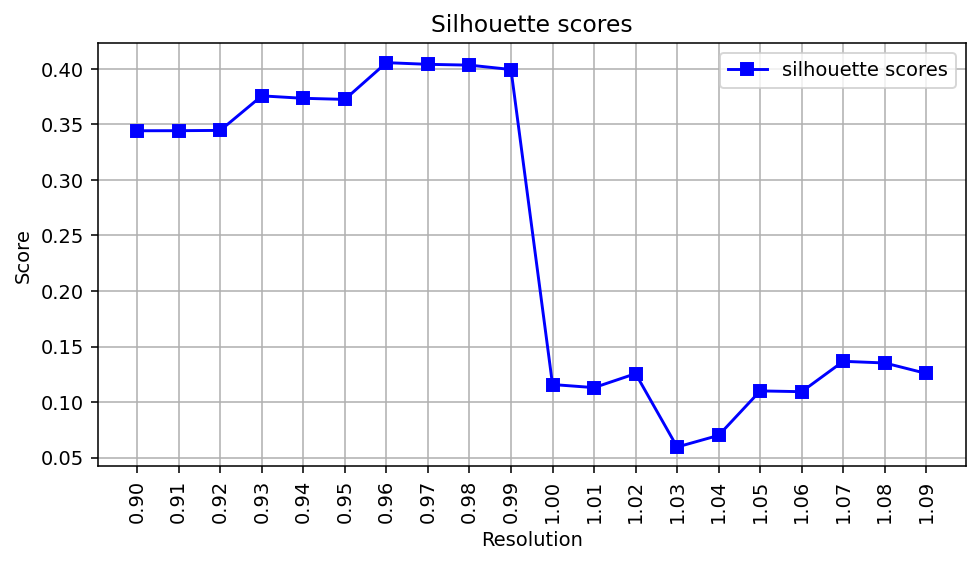

In [106]:
louvian_silhouettes, louvian_maxindex = louvian_scores(pge_umap_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Best Score is 0.5553455352783203 for Components: 12


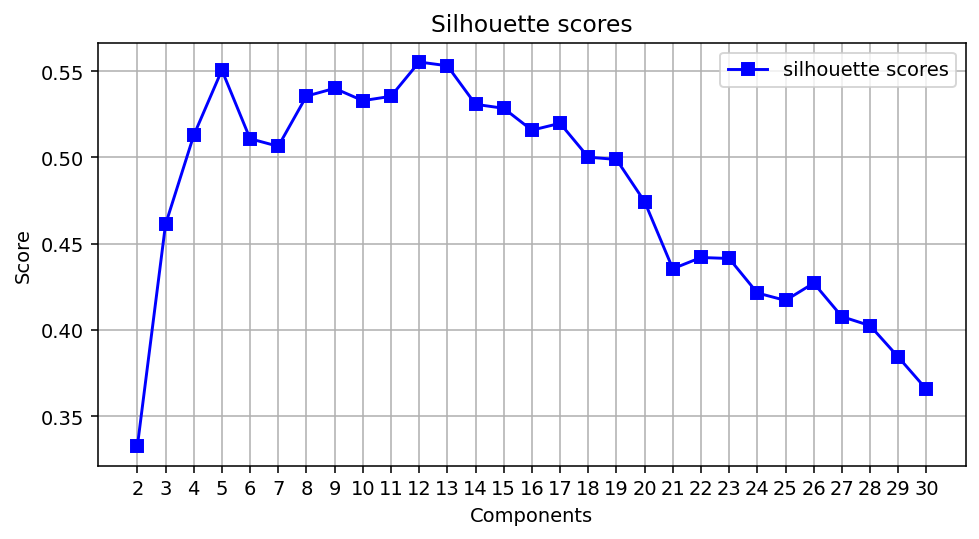

In [107]:
gmm_silhouettes, gmm_maxindex = gmm_scores(pge_umap_feature, component)
plot_gmm_scores(gmm_silhouettes)
print(f'Best Score is {max(gmm_silhouettes)} for Components: {gmm_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,2218
1,386
2,551
3,617
4,1003
5,104
6,121


Louvain assignment counts


,Number of members
Cluster Index,
0,1820
1,1534
2,1527
3,119


,Kmeans,Louvain
Metrics,,
silhouette,0.615687,0.405534
V-measure,0.524363,0.363778


GMM assignment counts


,Number of members
Cluster Index,
0,319
1,551
2,386
3,146
4,104
5,468
6,354
7,120
8,1016


,Kmeans,Louvain,GMM
Metrics,,,
silhouette,0.615687,0.405534,0.555346
V-measure,0.524363,0.363778,0.570119


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_12632\474630691.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



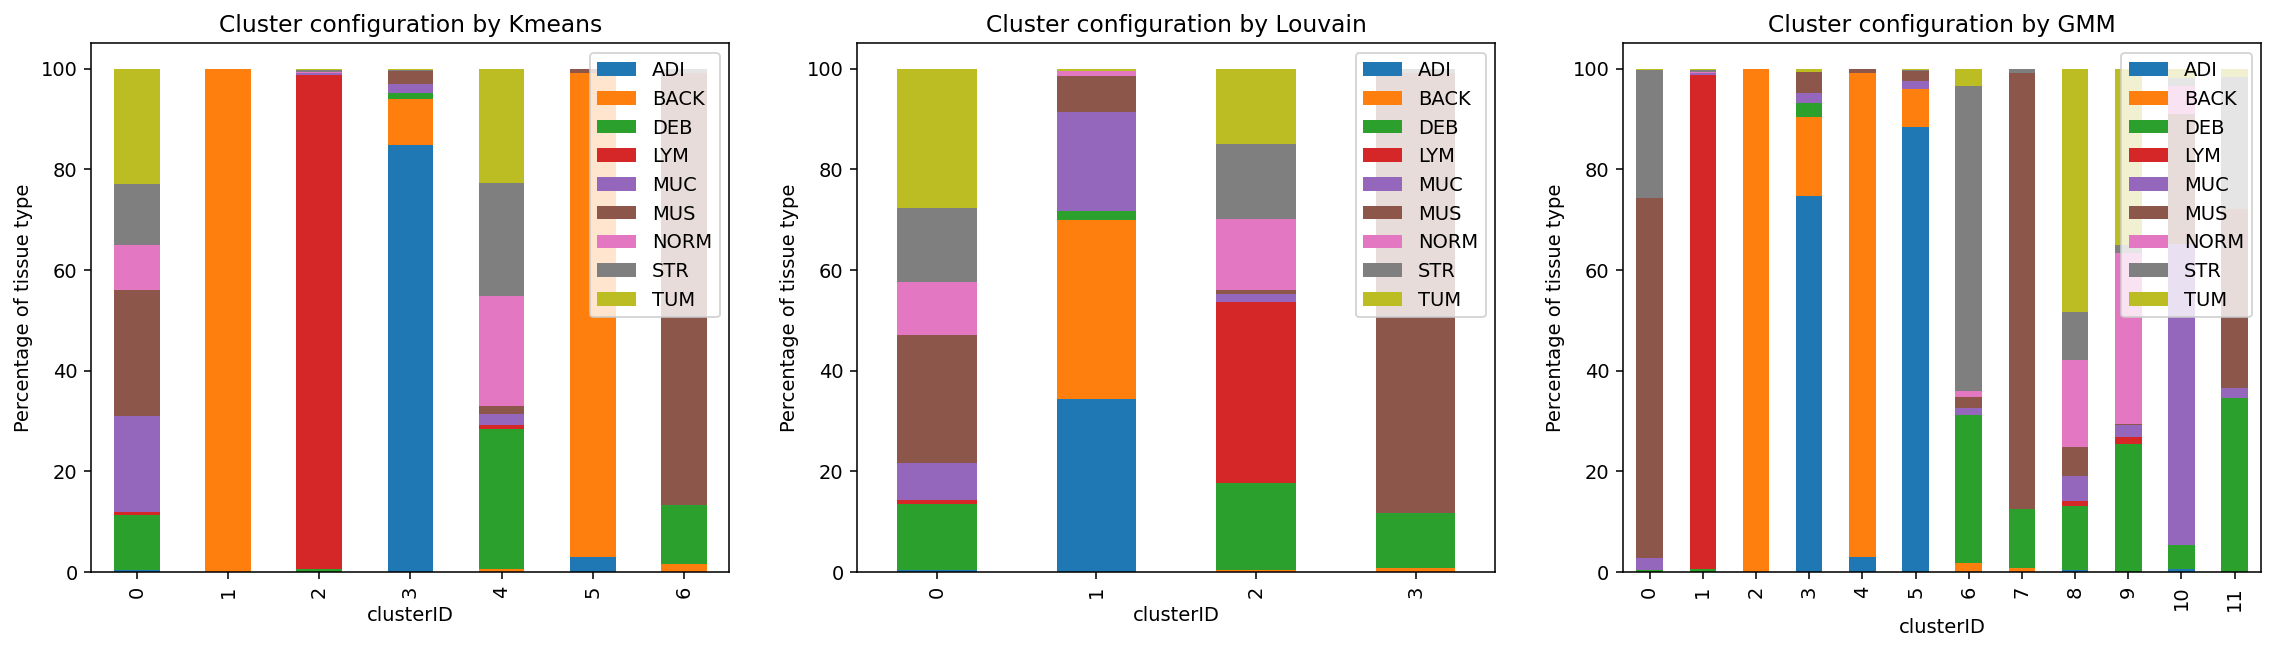

In [108]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(pge_umap_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(pge_umap_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

gmm_model = GaussianMixture(n_components = gmm_maxindex, random_state = 0) 
gmm_assignment = gmm_model.fit_predict(pge_umap_feature)

display_info(kmeans_assignment,louvain_assignment,gmm_assignment,pge_umap_feature)
show_assignments(kmeans_assignment,louvain_assignment,gmm_assignment)

Best Score is 0.33123019337654114 for Clusters: 2


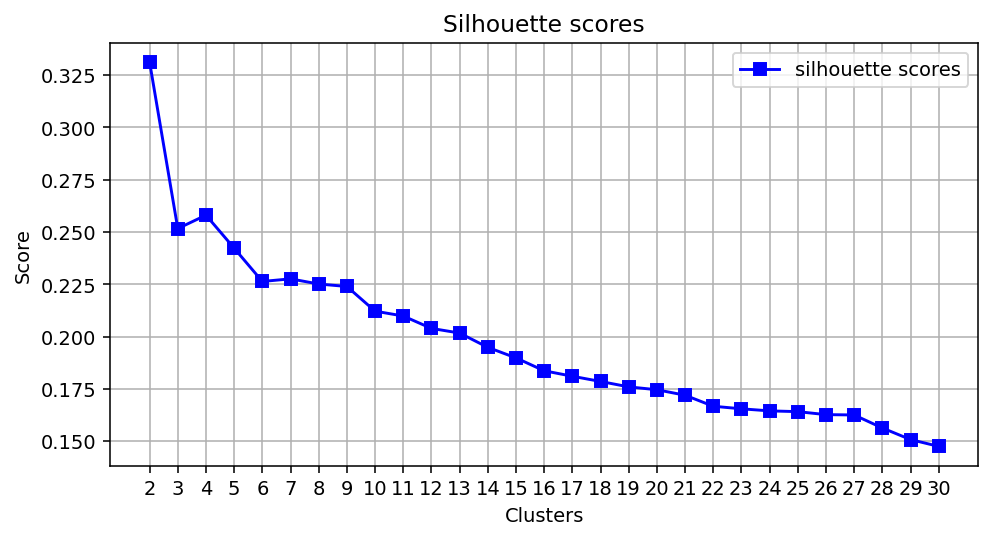

In [109]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(inceptionv3_pca_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.06496866792440414 for Resolution: 0.92


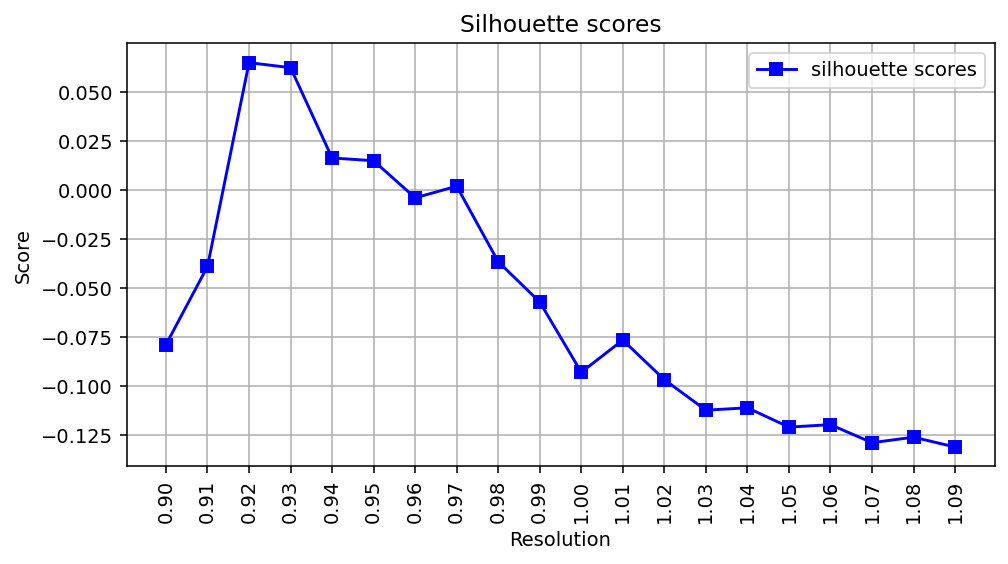

In [110]:
louvian_silhouettes, louvian_maxindex = louvian_scores(inceptionv3_pca_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Best Score is 0.3129279613494873 for Components: 2


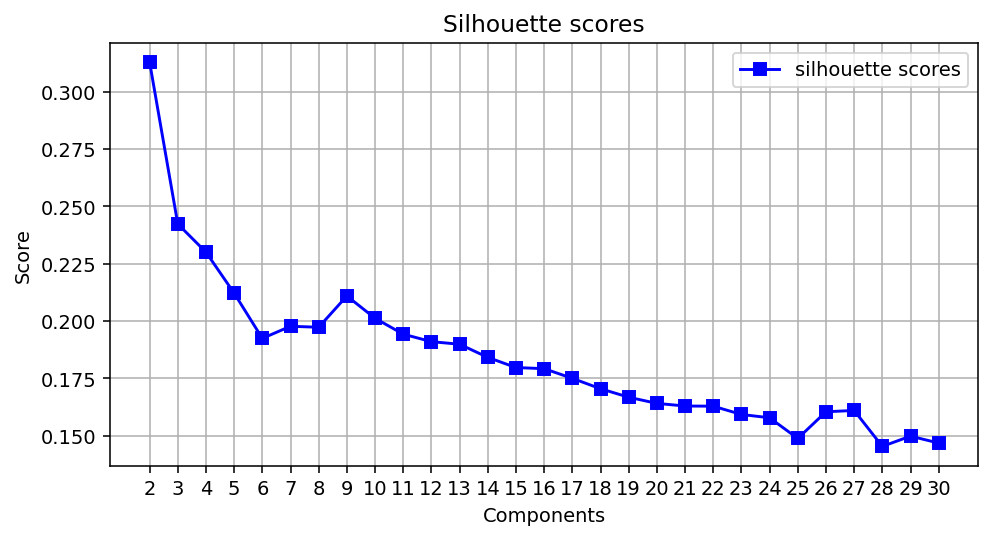

In [111]:
gmm_silhouettes, gmm_maxindex = gmm_scores(inceptionv3_pca_feature, component)
plot_gmm_scores(gmm_silhouettes)
print(f'Best Score is {max(gmm_silhouettes)} for Components: {gmm_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,1207
1,3793


Louvain assignment counts


,Number of members
Cluster Index,
0,2417
1,1856
2,725
3,2


,Kmeans,Louvain
Metrics,,
silhouette,0.331230,0.064969
V-measure,0.209789,0.174778


GMM assignment counts


,Number of members
Cluster Index,
0,3756
1,1244


,Kmeans,Louvain,GMM
Metrics,,,
silhouette,0.331230,0.064969,0.312928
V-measure,0.209789,0.174778,0.238273


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_12632\474630691.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



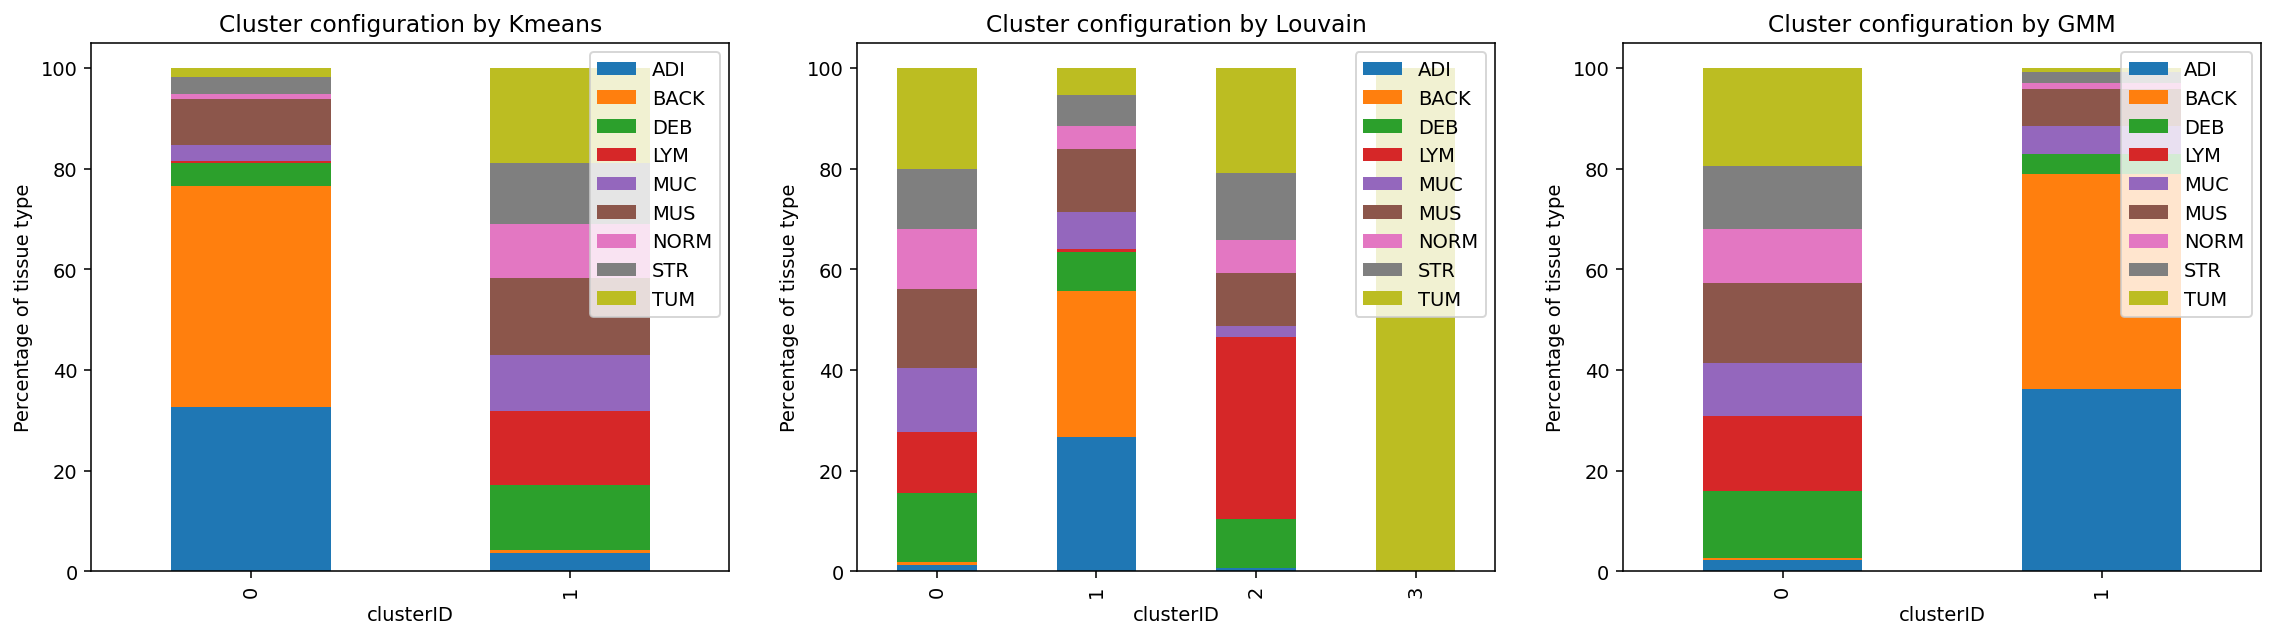

In [112]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(inceptionv3_pca_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(inceptionv3_pca_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

gmm_model = GaussianMixture(n_components = gmm_maxindex, random_state = 0) 
gmm_assignment = gmm_model.fit_predict(inceptionv3_pca_feature)

display_info(kmeans_assignment,louvain_assignment,gmm_assignment,inceptionv3_pca_feature)
show_assignments(kmeans_assignment,louvain_assignment,gmm_assignment)

Best Score is 0.6047378778457642 for Clusters: 2


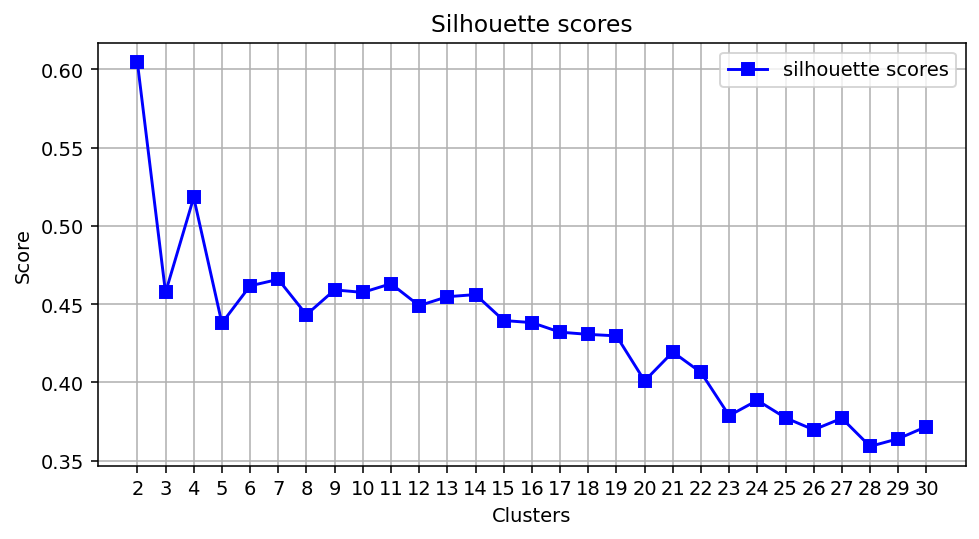

In [113]:
kmeans_silhouettes, kmeans_maxindex = k_means_scores(inceptionv3_umap_feature, cluster)
plot_kmeans_scores(kmeans_silhouettes)
print(f'Best Score is {max(kmeans_silhouettes)} for Clusters: {kmeans_maxindex}')

Best Score is 0.35515129566192627 for Resolution: 0.98


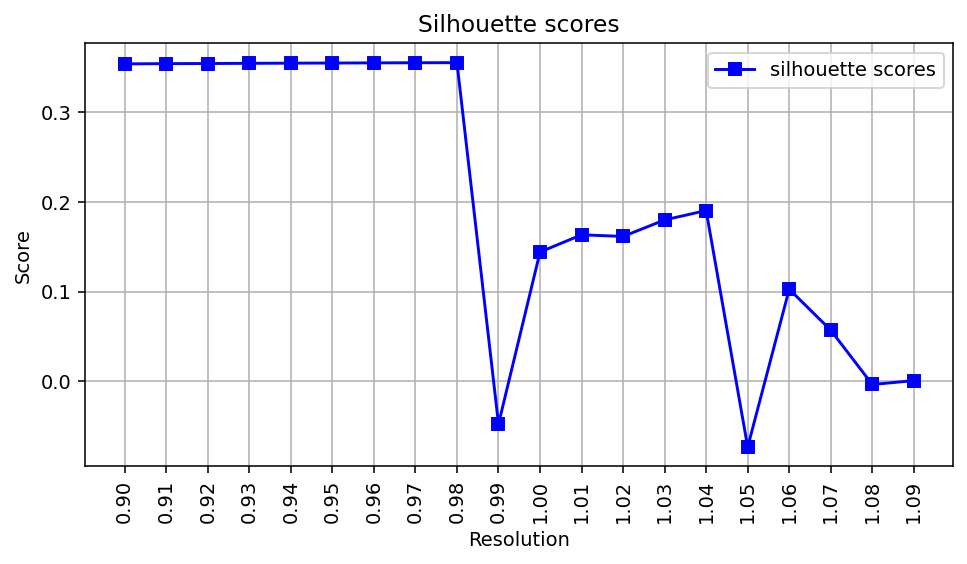

In [114]:
louvian_silhouettes, louvian_maxindex = louvian_scores(inceptionv3_umap_feature, start_res, obj_func, random_state, max_res)
plot_louvian_scores(louvian_silhouettes, start_res, max_res)
print(f'Best Score is {max(louvian_silhouettes)} for Resolution: {louvian_maxindex}')

Best Score is 0.5081390142440796 for Components: 4


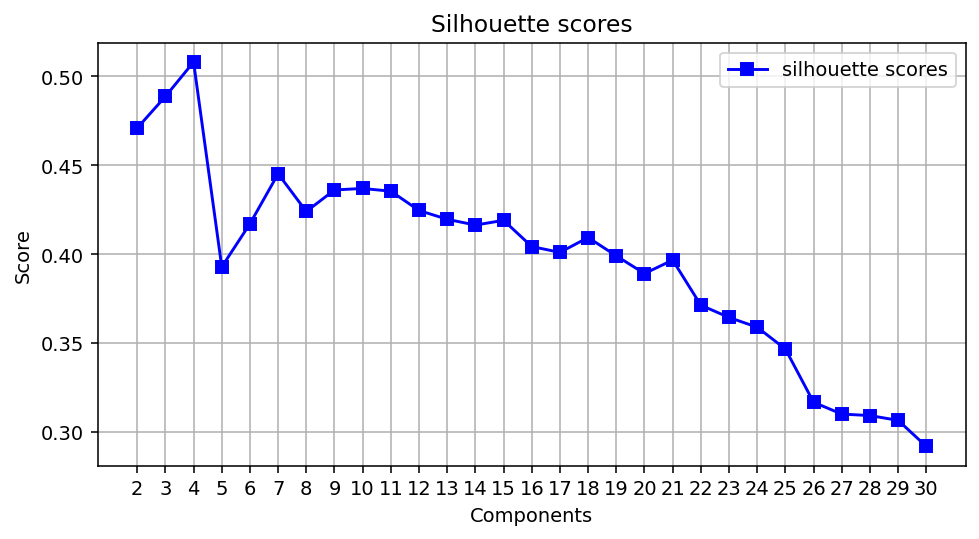

In [115]:
gmm_silhouettes, gmm_maxindex = gmm_scores(inceptionv3_umap_feature, component)
plot_gmm_scores(gmm_silhouettes)
print(f'Best Score is {max(gmm_silhouettes)} for Components: {gmm_maxindex}')

Kmeans assignment counts


,Number of members
Cluster Index,
0,4670
1,330


Louvain assignment counts


,Number of members
Cluster Index,
0,2839
1,2161


,Kmeans,Louvain
Metrics,,
silhouette,0.604738,0.355151
V-measure,0.134984,0.158933


GMM assignment counts


,Number of members
Cluster Index,
0,1699
1,2203
2,330
3,768


,Kmeans,Louvain,GMM
Metrics,,,
silhouette,0.604738,0.355151,0.508139
V-measure,0.134984,0.158933,0.340843


C:\Users\Sahil Gaurkar\AppData\Local\Temp\ipykernel_12632\474630691.py:40: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



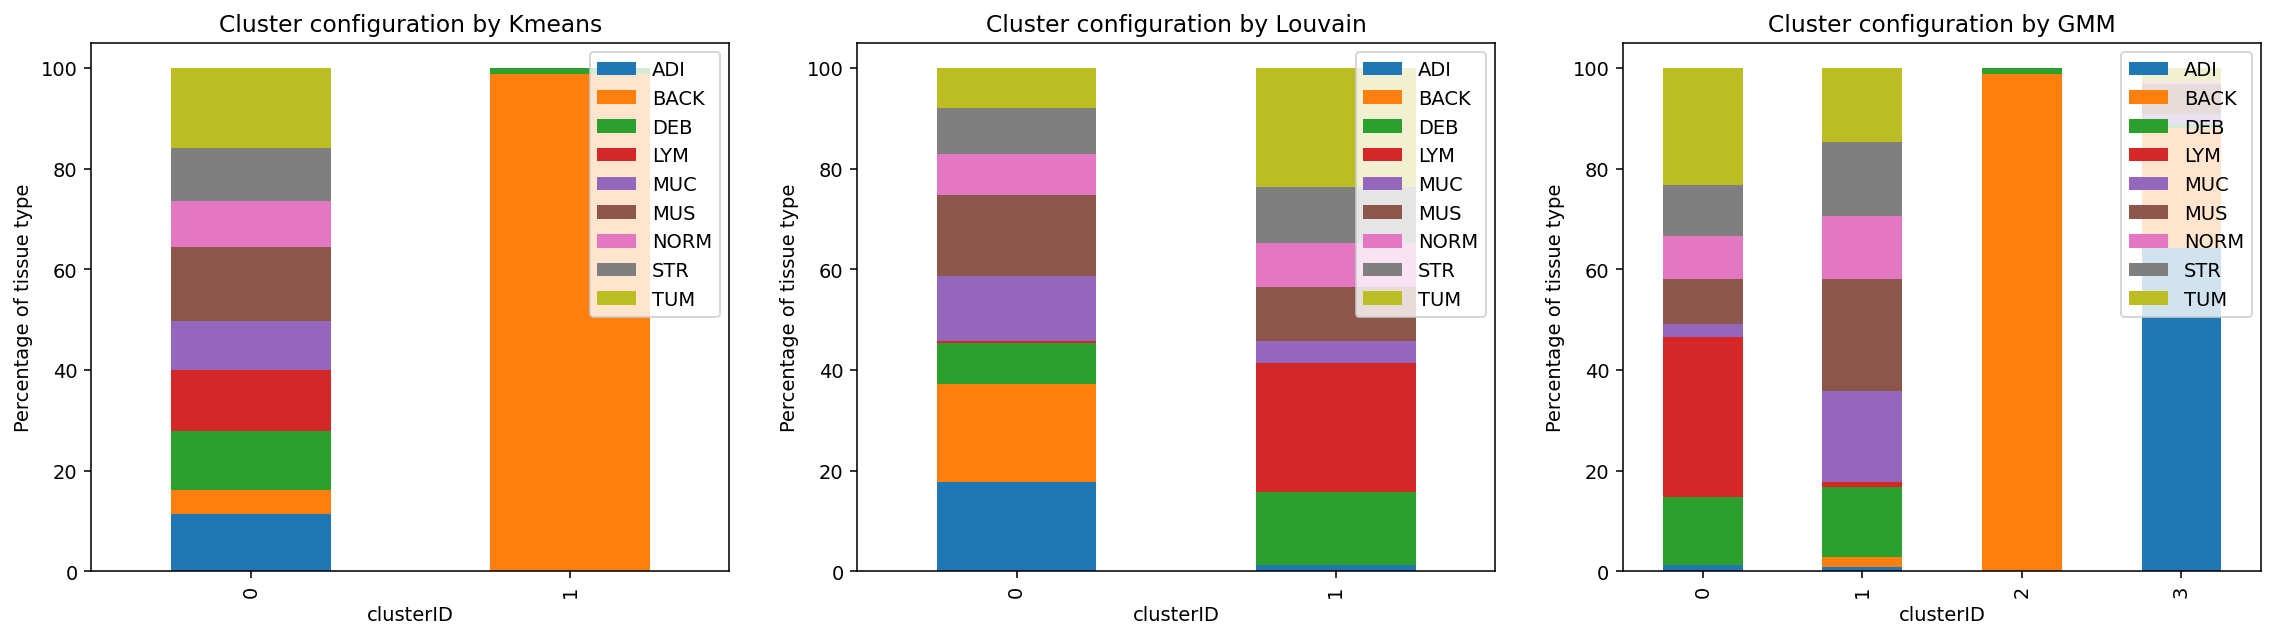

In [116]:
kmeans_model = KMeans(n_clusters = kmeans_maxindex, random_state = 0) 
kmeans_assignment = kmeans_model.fit_predict(inceptionv3_umap_feature)

louvain_model = Louvain(resolution = louvian_maxindex, modularity = obj_func, random_state=0) 
adjacency_matrix = sparse.csr_matrix(MinMaxScaler().fit_transform(-pairwise_distances(inceptionv3_umap_feature)))
louvain_assignment = louvain_model.fit_transform(adjacency_matrix)

gmm_model = GaussianMixture(n_components = gmm_maxindex, random_state = 0) 
gmm_assignment = gmm_model.fit_predict(inceptionv3_umap_feature)

display_info(kmeans_assignment,louvain_assignment,gmm_assignment,inceptionv3_umap_feature)
show_assignments(kmeans_assignment,louvain_assignment,gmm_assignment)